In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import miceforest as mf

sns.set()

In [28]:
response_vars_df1 = pd.read_csv("data/imputed_response_df_iter0")
response_vars_df1.shape

(3671, 226)

In [30]:
de_var_names = [col for col in response_vars_df1.columns if "DE" in col]
response_vars_df1["DE_sum"] = response_vars_df1.loc[:,de_var_names].sum(axis=1)

binary_positive_vars = [(str(col).upper())+"_DUMMY1" for col in ("dncl10w2,dncl11w2,dncl12w2,pncl1w2,pncl2w2,"+\
                        "pncl7w2,pncl12w2,pncl13w2,cscaw2,clhcw2,flihcw2,tomenw2,"+\
                        "tomepgw2,tomelnw2,tomesuw2,tomehdw2,dncl9w2,dncl10w2,dncl11w2,"+\
                        "dncl12w2,cbnpw2").split(",")]
binary_negative_vars = [(str(col).upper())+"_DUMMY1" for col in ("dncl1w2,dncl2w2,dncl3w2,dncl4w2,dncl5w2,dncl6w2,"+\
                        "dncl7w2,dncl8w2,dncl14w2,pncl3w2,pncl4w2,pncl5w2,pncl6w2,cilw2,cflw2,"+\
                        "cmosw2,cbiw2,cgiw2,tomeew2,tomempw2,tomergw2,"+\
                        "tomerbw2,tomemfw2,tomepmw2,tomethpw2,tomerew2,tomesgw2").split(",")]
cat3_positive_vars = [col+str(i) for col in [(str(col).upper())+"_DUMMY" for col in \
                      ("infdw2,infcw2").split(",")] for i in range(1,3)]
cat4_positive_vars = [col+str(i) for col in [(str(col).upper())+"_DUMMY" for col in \
                      ("dn9w2,dn10w2,dn11w2,dn12w2").split(",")] for i in range(1,4)]
cat4_negative_vars = [col+str(i) for col in [(str(col).upper())+"_DUMMY" for col in \
                      ("dn14w2,dn1w2,dn2w2,dn3w2,dn4w2,dn5w2,dn6w2,dn7w2,dn8w2").split(",")]\
                       for i in range(1,4)]
cat5_positive_vars = [col+str(i) for col in [(str(col).upper())+"_DUMMY" for col in \
                      ("pn1w2,pn2w2,pn10w2,pn11w2,pn12w2,pn13w2").split(",")]\
                      for i in range(1,5)]
cat5_negative_vars = [col+str(i) for col in [(str(col).upper())+"_DUMMY" for col in \
                      ("pn3w2,pn4w2,pn5w2,pn6w2,pn7w2,pn9w2").split(",")]\
                       for i in range(1,5)]
#cat3_negative_vars: none

response_vars_df1["binary_vars"] = response_vars_df1.loc[:,binary_positive_vars]\
.sum(axis=1) - response_vars_df1.loc[:,binary_negative_vars].sum(axis=1)

<AxesSubplot:>

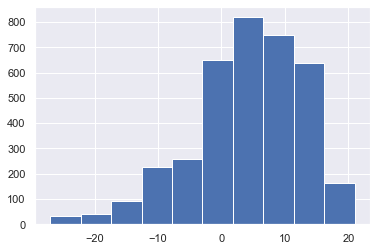

In [32]:
response_vars_df1["binary_vars"].hist()

In [ ]:
def create_composite_vars(full_df):
    return composite_vars